Notebook creating features predicting exit velocity given features from the swing

Based on Driveline's OpenBiomechanics hitting dataset (credits: https://www.openbiomechanics.org/ )

In [3]:
# import modules
import numpy as np
import pandas as pd


## load data from driveline openbiomechanics dataset poi_metrics.csv on github
url = "https://raw.githubusercontent.com/drivelineresearch/openbiomechanics/main/baseball_hitting/data/poi/poi_metrics.csv"
data = pd.read_csv(url)


Columns with missing values:
exit_velo_mph_x           5
blast_bat_speed_mph_x    30
dtype: int64

Original shape: (677, 126)
Shape after cleaning: (642, 126)

Selected features (correlation > 0.3):
bat_speed_mph_max_x: 0.715
bat_speed_mph_contact_x: 0.714
sweet_spot_velo_mph_contact_x: 0.678
bat_speed_xy_max_x: 0.630
blast_bat_speed_mph_x: 0.575
hand_speed_blast_bat_mph_max_x: 0.449
hand_speed_mag_max_x: 0.320
hand_speed_mag_seq_max_x: 0.320
hand_speed_mag_swing_max_velo_x: 0.317
pelvis_angular_velocity_fp_x: 0.309
upper_arm_speed_mag_swing_max_velo_x: 0.305
upper_arm_speed_mag_max_x: 0.305
upper_arm_speed_mag_seq_max_x: 0.305

Model R-squared: 0.6082308778023464

Top 5 Most Important Features:
                           Feature  Coefficient  Abs_Coefficient
1          bat_speed_mph_contact_x     2.583850         2.583850
3               bat_speed_xy_max_x     1.524210         1.524210
0              bat_speed_mph_max_x     0.928777         0.928777
9     pelvis_angular_velocity_fp_x

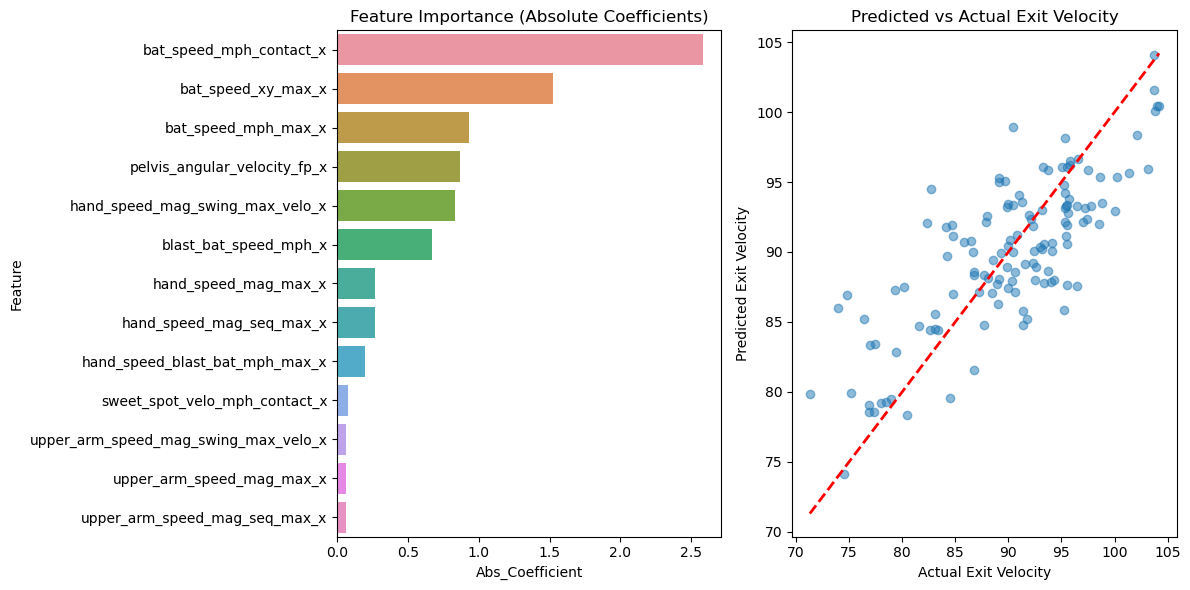

In [4]:
"""
This cell contains functions to clean and analyze pitch data from the driveline openbiomechanics dataset.


"""

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

def clean_swing_data(df):
    """
    Clean the swing data by removing infinite values and handling NaN values.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing swing data
    
    Returns:
    pandas.DataFrame: Cleaned DataFrame
    """
    # Make a copy to avoid modifying original data
    df_clean = df.copy()
    
    # Replace infinite values with NaN
    df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
    
    # Print columns with NaN values and their count
    nan_cols = df_clean.isna().sum()
    print("\nColumns with missing values:")
    print(nan_cols[nan_cols > 0])
    
    # Remove rows with any NaN values
    df_clean = df_clean.dropna()
    
    # Reset index to ensure clean integer index
    df_clean = df_clean.reset_index(drop=True)
    
    print(f"\nOriginal shape: {df.shape}")
    print(f"Shape after cleaning: {df_clean.shape}")
    
    return df_clean

def analyze_exit_velocity(df, target='exit_velo_mph_x', test_size=0.2, correlation_threshold=0.3):
    """
    Perform multiple regression analysis on swing data to identify factors contributing to exit velocity.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing swing data
    target (str): Name of the target variable (default: 'ReleaseSpeed')
    test_size (float): Proportion of data to use for testing (default: 0.2)
    correlation_threshold (float): Minimum correlation coefficient to include variable (default: 0.3)
    
    Returns:
    dict: Dictionary containing regression results and feature importance
    """
    # Clean the data first
    df_clean = clean_swing_data(df)
    
    # Get correlations and filter features
    correlations = df_clean.corr()[target].sort_values(ascending=False)
    selected_features = correlations[abs(correlations) > correlation_threshold].index.tolist()
    selected_features.remove(target)
    
    print(f"\nSelected features (correlation > {correlation_threshold}):")
    for feat in selected_features:
        print(f"{feat}: {correlations[feat]:.3f}")
    
    # Prepare features and target
    X = df_clean[selected_features].copy()  # Make explicit copies
    y = df_clean[target].copy()
    
    # Ensure indices match
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=42)
    
    # Reset indices after split to ensure alignment
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    # Fit OLS regression for detailed statistics
    X_train_sm = sm.add_constant(X_train)
    model_sm = sm.OLS(y_train, X_train_sm).fit()
    
    # Fit sklearn model for predictions
    model_sk = LinearRegression()
    model_sk.fit(X_train, y_train)
    
    # Calculate feature importance
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': model_sk.coef_,
        'Abs_Coefficient': abs(model_sk.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    # Calculate predictions and R-squared
    y_pred = model_sk.predict(X_test)
    r2_score = model_sk.score(X_test, y_test)
    
    # Create visualizations
    plt.figure(figsize=(12, 6))
    
    # Feature importance plot
    plt.subplot(1, 2, 1)
    sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importance)
    plt.title('Feature Importance (Absolute Coefficients)')
    
    # Predicted vs Actual plot
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Exit Velocity')
    plt.ylabel('Predicted Exit Velocity')
    plt.title('Predicted vs Actual Exit Velocity')
    
    plt.tight_layout()
    
    return {
        'model_summary': model_sm.summary(),
        'feature_importance': feature_importance,
        'r2_score': r2_score,
        'model': model_sk,
        'selected_features': selected_features,
        'clean_data': df_clean
    }


# remove unnecessary columns
swing_data = data.drop(columns=['session_swing'])




results = analyze_exit_velocity(swing_data)
print("\nModel R-squared:", results['r2_score'])
print("\nTop 5 Most Important Features:")
print(results['feature_importance'].head())
print("\nDetailed Statistics:")
print(results['model_summary']) 

In [6]:
# # Run a standard correlation on the event data and pitch_speed_mph
# correlation = event_data.corr()['pitch_speed_mph'].sort_values(ascending=False)
# print(correlation)

# Run a standard correlation on fastball data and pitch_speed_mph
correlation = swing_data.corr()['exit_velo_mph_x'].sort_values(ascending=False)
print(correlation)

exit_velo_mph_x                  1.000000
bat_speed_mph_max_x              0.708174
bat_speed_mph_contact_x          0.707758
sweet_spot_velo_mph_contact_x    0.673727
bat_speed_xy_max_x               0.625178
                                   ...   
pelvis_angle_fp_y               -0.148646
pelvis_launchpos_y              -0.148646
torso_pelvis_launchpos_x        -0.153218
x_factor_fp_z                   -0.153218
pelvis_stride_max_z             -0.161143
Name: exit_velo_mph_x, Length: 126, dtype: float64


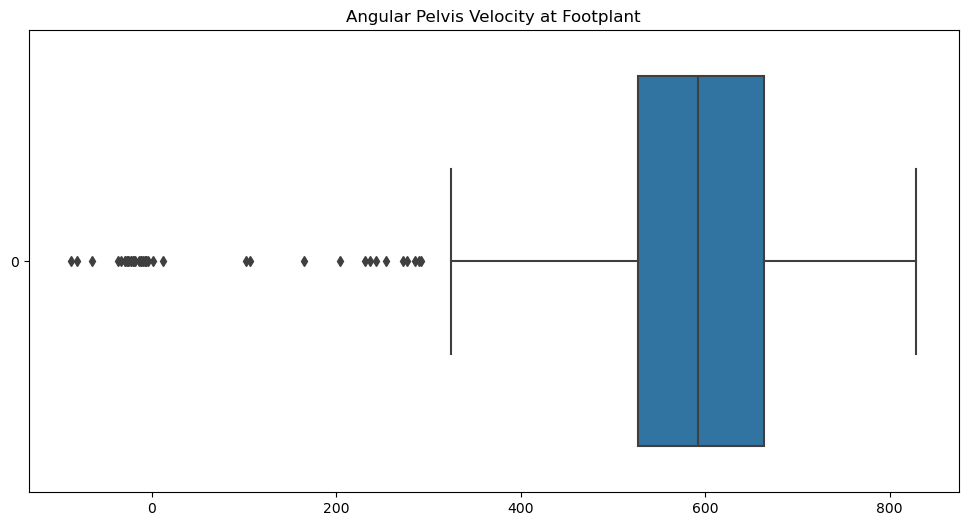

c:\Users\jaspe\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


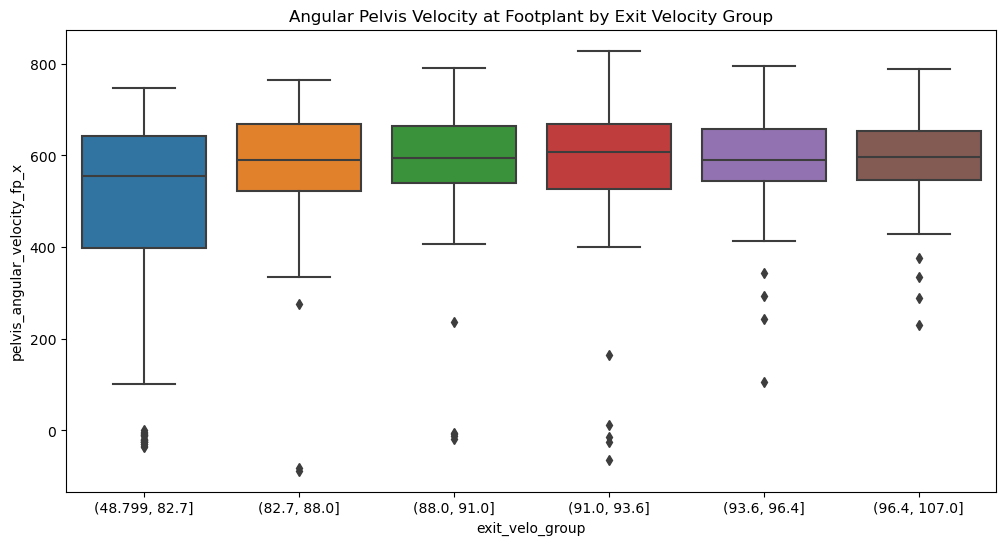

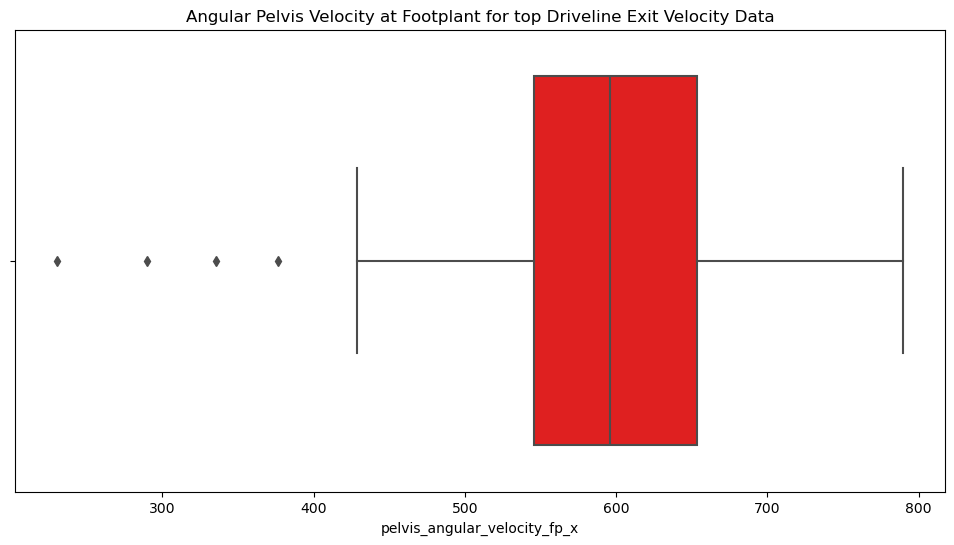

In [7]:
# Horizontal boxplot of pelvis_angular_velocity_fp_x
plt.figure(figsize=(12, 6))
sns.boxplot(data['pelvis_angular_velocity_fp_x'], orient = 'h')
plt.title('Angular Pelvis Velocity at Footplant')
plt.show()

# Split data into 5 groups based on pitch velocity (pitch_speed_mph) and plot pelvis_angular_velocity_fp_x
data['exit_velo_group'] = pd.qcut(data['exit_velo_mph_x'], q=6)
plt.figure(figsize=(12, 6))
sns.boxplot(x='exit_velo_group', y='pelvis_angular_velocity_fp_x', data=data, orient='v')
plt.title('Angular Pelvis Velocity at Footplant by Exit Velocity Group')
plt.show()

# Rename the pitch group witht the highest velocity to 'Fastest' and plot just that one
data['exit_velo_group'] = data['exit_velo_group'].cat.rename_categories(['Slowest', '2', '3', '4', '5', 'Fastest'])
fastest_group = data[data['exit_velo_group'] == 'Fastest']
plt.figure(figsize=(12, 6))
sns.boxplot(x='pelvis_angular_velocity_fp_x', data=fastest_group, orient='h', color='red')
plt.title('Angular Pelvis Velocity at Footplant for top Driveline Exit Velocity Data')
plt.show()